In [1]:
# ===================== IMPORTS/LIBRARIES =====================

import tensorflow as tf
from mtcnn import MTCNN
from pathlib import Path
import pandas as pd
import glob
import cv2
import csv
import os
import ast
import pydot
import pydotplus
import graphviz
from datetime import datetime
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
import numpy as np
import time

from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import Callback

In [2]:
# ===================== TRAINING HISTORY FUNCTIONS =====================
def historyToCsv(history):
    # convert the history.history dict to a pandas DataFrame:     
    hist_df = pd.DataFrame(history.history) 
    
    current_datetime = datetime.now()

    # Convert the datetime object to a string
    filename_friendly_datetime_string = current_datetime.strftime("%Y-%m-%d_%H-%M-%S")
    
    # save to csv: 
    hist_csv_file = 'history' + filename_friendly_datetime_string + '.csv'
    with open(hist_csv_file, mode='w') as f:
        hist_df.to_csv(f)

def csvToHistory(csv_filename):
    # Read the CSV file into a pandas DataFrame
    hist_df = pd.read_csv(csv_filename, index_col=0)

    # Convert the DataFrame to a dictionary
    history_dict = hist_df.to_dict(orient='list')

    return history_dict

In [2]:
# ===================== MULTITASK MODEL SETUP =====================
base_model = tf.keras.applications.VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)
)

flattened_features = tf.keras.layers.Flatten(name='flattened_features')(base_model.output)

embedding_layer = tf.keras.layers.Dense(512, activation='linear', name='embedding')(flattened_features)

additional_dense_layer1 = tf.keras.layers.Dense(64, activation='relu', name='additional_dense1')(embedding_layer)
additional_dense_layer2 = tf.keras.layers.Dense(64, activation='relu', name='additional_dense2')(additional_dense_layer1)

additional_dense_layer3 = tf.keras.layers.Dense(64, activation='relu', name='additional_dense3')(embedding_layer)
additional_dense_layer4 = tf.keras.layers.Dense(64, activation='relu', name='additional_dense4')(additional_dense_layer3)

# additional_dense_layer3 = tf.keras.layers.Dense(64, activation='relu', name='additional_dense3')(flattened_features)

landmarks = tf.keras.layers.Dense(10, activation='linear', name='landmark_output')(additional_dense_layer2)
illum = tf.keras.layers.Dense(1, activation='linear', name='previous_illuminance_output')(additional_dense_layer4)

# Reshape layer to the desired shape
# reshaped_features = tf.keras.layers.Reshape((8, 8, 8))(embedding_layer)

# Upsampling layers
# upsample1 = tf.keras.layers.UpSampling2D(size=(7, 7))(reshaped_features)
# upsample2 = tf.keras.layers.UpSampling2D(size=(2, 2))(upsample1)
# upsample3 = tf.keras.layers.UpSampling2D(size=(2, 2))(upsample2)

# retIllum = tf.keras.layers.Conv2D(3, kernel_size=(3, 3), activation='relu', padding='same', name='image_retinex_output')(upsample3)

task_outputs = None

task_outputs = [landmarks, illum]

multi_task_model = tf.keras.Model(inputs=base_model.input, outputs=task_outputs)

# Compile the model with specific loss functions and metrics for each task
multi_task_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss={
        'landmark_output': 'mean_squared_error',
        'previous_illuminance_output': 'mean_squared_error'
#         'image_retinex_output': 'mean_squared_error'
    },
    metrics={
        'landmark_output': ['mse', "mae"],
        'previous_illuminance_output': ['mse', "mae"]
#         'image_retinex_output': ['mse', "mae"]
    }
)

# Summary of the multi-task model
multi_task_model.summary()
# plot_model(multi_task_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 224, 224, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 224, 224, 64  36928       ['block1_conv1[0][0]']           
                                )                                                             

In [18]:
# ===================== MULTI-TASK DATA GEN =====================

class CustomDataGen(tf.keras.utils.Sequence):
    
    def __init__(self, df, X_col, y_col,
                 batch_size,
                 input_size=(224, 224, 3),
                 shuffle=True,
                 random_seed=None):  # Add a new parameter for random seed
        
        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.batch_size = batch_size
        self.input_size = input_size
        self.shuffle = shuffle
        self.random_seed = random_seed  # Store the random seed
        
        self.n = len(self.df)
        self.n_coords = 2  # Assuming landmark coordinates are 2-dimensional
        self.n_illuminance = 1  # Assuming a single illuminance value
    
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1, random_state=self.random_seed).reset_index(drop=True)  # Use the random seed
    
    def __get_input(self, path, target_size):
    
        image = tf.keras.preprocessing.image.load_img(path)
        image_arr = tf.keras.preprocessing.image.img_to_array(image)

        image_arr = tf.image.resize(image_arr, (target_size[0], target_size[1])).numpy()

        return image_arr / 255.
    
    def __get_output(self, label, output_type):
        # Assuming output_type is 'coordinates', 'illuminance', or 'adjusted_image_path'
        if output_type == 'coordinates':
            # Assuming label is a string containing a dictionary-like structure
            # Safely evaluate the string as a literal dictionary using ast.literal_eval
            coordinates_dict = ast.literal_eval(label)
            
            # Extract x and y coordinates for each landmark
            landmarks = ['left_eye', 'right_eye', 'nose', 'mouth_left', 'mouth_right']
            coordinates_list = [coordinates_dict[landmark] for landmark in landmarks]
            
            # Flatten the list and convert to numpy array
            coordinates_array = np.array([coord for landmark_coords in coordinates_list for coord in landmark_coords])
            
            coordinates_array = normalize_coordinates(coordinates_array, 640, 480)

#             print("Shape of landmarks_array:", coordinates_array.shape)
            
            # If there are exactly 10 values, return the array, otherwise raise an error
            if len(coordinates_array) == 10:
                return coordinates_array
            else:
                raise ValueError("Expected 10 coordinates, but found {}".format(len(coordinates_array)))
        elif output_type == 'illuminance':
            # Convert the illuminance value to a float
            return float(label)
#         elif output_type == 'adjusted_image_path':
#             # Assuming label is the path to the adjusted image
#             return self.__get_input(label, self.input_size)
    
    def __get_data(self, batches):
        # Generates data containing batch_size samples

        path_batch = batches[self.X_col['path']]
        
        coords_batch = batches[self.y_col['coordinates']]
        illuminance_batch = batches[self.y_col['illuminance']]
#         adjusted_image_path_batch = batches[self.y_col['adjusted_image_path']]

        X_batch = np.asarray([self.__get_input(x, self.input_size) for x in path_batch])

        y0_batch = np.asarray([self.__get_output(y, 'coordinates') for y in coords_batch])
        y1_batch = np.asarray([self.__get_output(y, 'illuminance') for y in illuminance_batch])
#         y2_batch = np.asarray([self.__get_output(y, 'adjusted_image_path') for y in adjusted_image_path_batch])

        return X_batch, [y0_batch, y1_batch]
    
    def __getitem__(self, index):
        batches = self.df[index * self.batch_size:(index + 1) * self.batch_size]
        X, y = self.__get_data(batches)
        
        return X, y
    
    def __len__(self):
        return self.n // self.batch_size

def normalize_coordinates(coordinates, original_width, original_height):
    normalized_coordinates = np.zeros_like(coordinates, dtype=np.float32)
    
    for i in range(0, len(coordinates), 2):
        x = coordinates[i]
        y = coordinates[i + 1]
        
        normalized_x = (x / original_width)
        normalized_y = (y / original_height)
        
        normalized_coordinates[i] = normalized_x
        normalized_coordinates[i + 1] = normalized_y
    
    return normalized_coordinates

In [6]:
class DynamicLearningRateScheduler(Callback):
    def __init__(self, monitor_metric='val_loss', patience=3, factor=0.5, min_lr=1e-6):
        super(DynamicLearningRateScheduler, self).__init__()
        self.monitor_metric = monitor_metric
        self.patience = patience
        self.factor = factor
        self.min_lr = min_lr
        self.wait = 0
        self.best_metric = float('inf')

    def on_epoch_end(self, epoch, logs=None):
        current_metric = logs.get(self.monitor_metric)

        if current_metric is None:
            raise ValueError(f"Metric {self.monitor_metric} not found in training logs.")

        if current_metric < self.best_metric:
            self.best_metric = current_metric
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                new_lr = max(self.model.optimizer.lr * self.factor, self.min_lr)
                self.model.optimizer.lr = new_lr
                print(f"\nLearning rate reduced to {new_lr}.")
                self.wait = 0

dynamicLearningCallback = DynamicLearningRateScheduler(monitor_metric='val_loss', patience=3, factor=0.5, min_lr=1e-6)

In [22]:
# ===================== DATA GEN SETUP (LANDMARKS and ILLUMINANCE TASKS) =====================

train_df = pd.read_csv("./data/training.csv") # path to train_data csv
train_df["Filename"] = "./data/Training/" + train_df["Filename"]

# Define column indices or names for X and y
X_col = {'path': 'Filename'}
y_col = {'coordinates': 'Landmarks', 'illuminance': 'Illuminance'}

# Create an instance of CustomDataGen
train_gen = CustomDataGen(train_df, X_col, y_col, batch_size=32, input_size=(224, 224, 3), random_seed=438)

eval_df = pd.read_csv("./data/evaluation.csv") # path to eval_data csv
eval_df["Filename"] = "./data/Evaluation/Evaluation/" + eval_df["Filename"]

# Define column indices or names for X and y
eval_X_col = {'path': 'Filename'}
eval_y_col = {'coordinates': 'Landmarks', 'illuminance': 'Illuminance'}

val_gen = CustomDataGen(eval_df, eval_X_col, eval_y_col, batch_size=32, input_size=(224, 224, 3), random_seed=438)

In [23]:
history = multi_task_model.fit(train_gen, epochs=20, validation_data=val_gen, callbacks=[dynamicLearningCallback])

Epoch 1/20
940/940 [==============================] - 1083s 1s/step - loss: 0.0116 - landmark_output_loss: 0.0102 - previous_illuminance_output_loss: 0.0014 - landmark_output_mse: 0.0102 - landmark_output_mae: 0.0645 - previous_illuminance_output_mse: 0.0014 - previous_illuminance_output_mae: 0.0290 - val_loss: 0.0066 - val_landmark_output_loss: 0.0062 - val_previous_illuminance_output_loss: 4.3634e-04 - val_landmark_output_mse: 0.0062 - val_landmark_output_mae: 0.0465 - val_previous_illuminance_output_mse: 4.3634e-04 - val_previous_illuminance_output_mae: 0.0178
Epoch 2/20
940/940 [==============================] - 762s 810ms/step - loss: 0.0041 - landmark_output_loss: 0.0040 - previous_illuminance_output_loss: 1.4874e-04 - landmark_output_mse: 0.0040 - landmark_output_mae: 0.0298 - previous_illuminance_output_mse: 1.4874e-04 - previous_illuminance_output_mae: 0.0095 - val_loss: 0.0043 - val_landmark_output_loss: 0.0041 - val_previous_illuminance_output_loss: 2.1060e-04 - val_landmark

Epoch 15/20
940/940 [==============================] - ETA: 0s - loss: 0.0283 - landmark_output_loss: 0.0196 - previous_illuminance_output_loss: 0.0087 - landmark_output_mse: 0.0196 - landmark_output_mae: 0.0850 - previous_illuminance_output_mse: 0.0087 - previous_illuminance_output_mae: 0.0875
Learning rate reduced to 2.499999936844688e-05.
940/940 [==============================] - 733s 780ms/step - loss: 0.0283 - landmark_output_loss: 0.0196 - previous_illuminance_output_loss: 0.0087 - landmark_output_mse: 0.0196 - landmark_output_mae: 0.0850 - previous_illuminance_output_mse: 0.0087 - previous_illuminance_output_mae: 0.0875 - val_loss: 0.0250 - val_landmark_output_loss: 0.0160 - val_previous_illuminance_output_loss: 0.0091 - val_landmark_output_mse: 0.0160 - val_landmark_output_mae: 0.0663 - val_previous_illuminance_output_mse: 0.0091 - val_previous_illuminance_output_mae: 0.0892
Epoch 16/20
940/940 [==============================] - 732s 779ms/step - loss: 0.0279 - landmark_output

In [25]:
# ===================== SAVE MODEL WEIGHTS =====================

multi_task_model.save('LandmarksIlluminanceModel.keras')

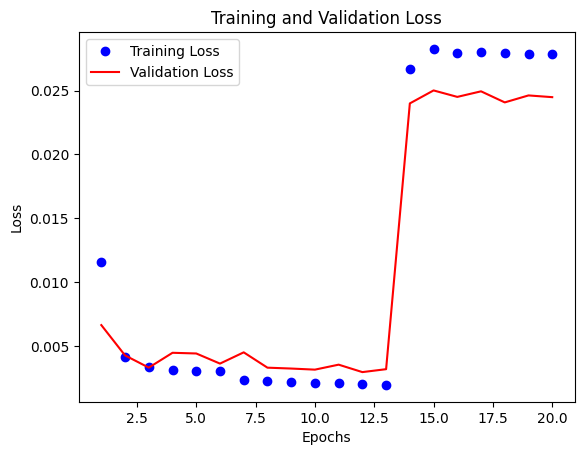

In [24]:
# Extract training and validation loss values
loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot training and validation loss
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()